In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda, Dense, Input
from keras.callbacks import ModelCheckpoint 

from keras import optimizers
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files 
from tqdm import tqdm

# Load and examine the dataset

In [2]:
def load_dataset(path):
    # the sklearn.datasets.load_files function takes a dataset directory as an input
    # for each folder within the directory, the folder name should be a category
    # within each folder will be samples corresponding to their category
    # load_files returns a bunch object which is a dictionary with 'DESC', 
    # 'data', 'filenames', 'target' as keys
    data = load_files(path)
    # an array of file paths or directories
    data_files = np.array(data['filenames']) 
    data_labels = np_utils.to_categorical(np.array(data['target']), 10)
    return data_files, data_labels

In [ ]:
train_data_dir = "imgs/train"
faked_data_dir = "faked/"
data_directory = faked_data_dir

In [3]:
train_files, train_labels = load_dataset(data_directory)
print("There are {} total training images.".format(len(train_files)))

There are 20 total training images.


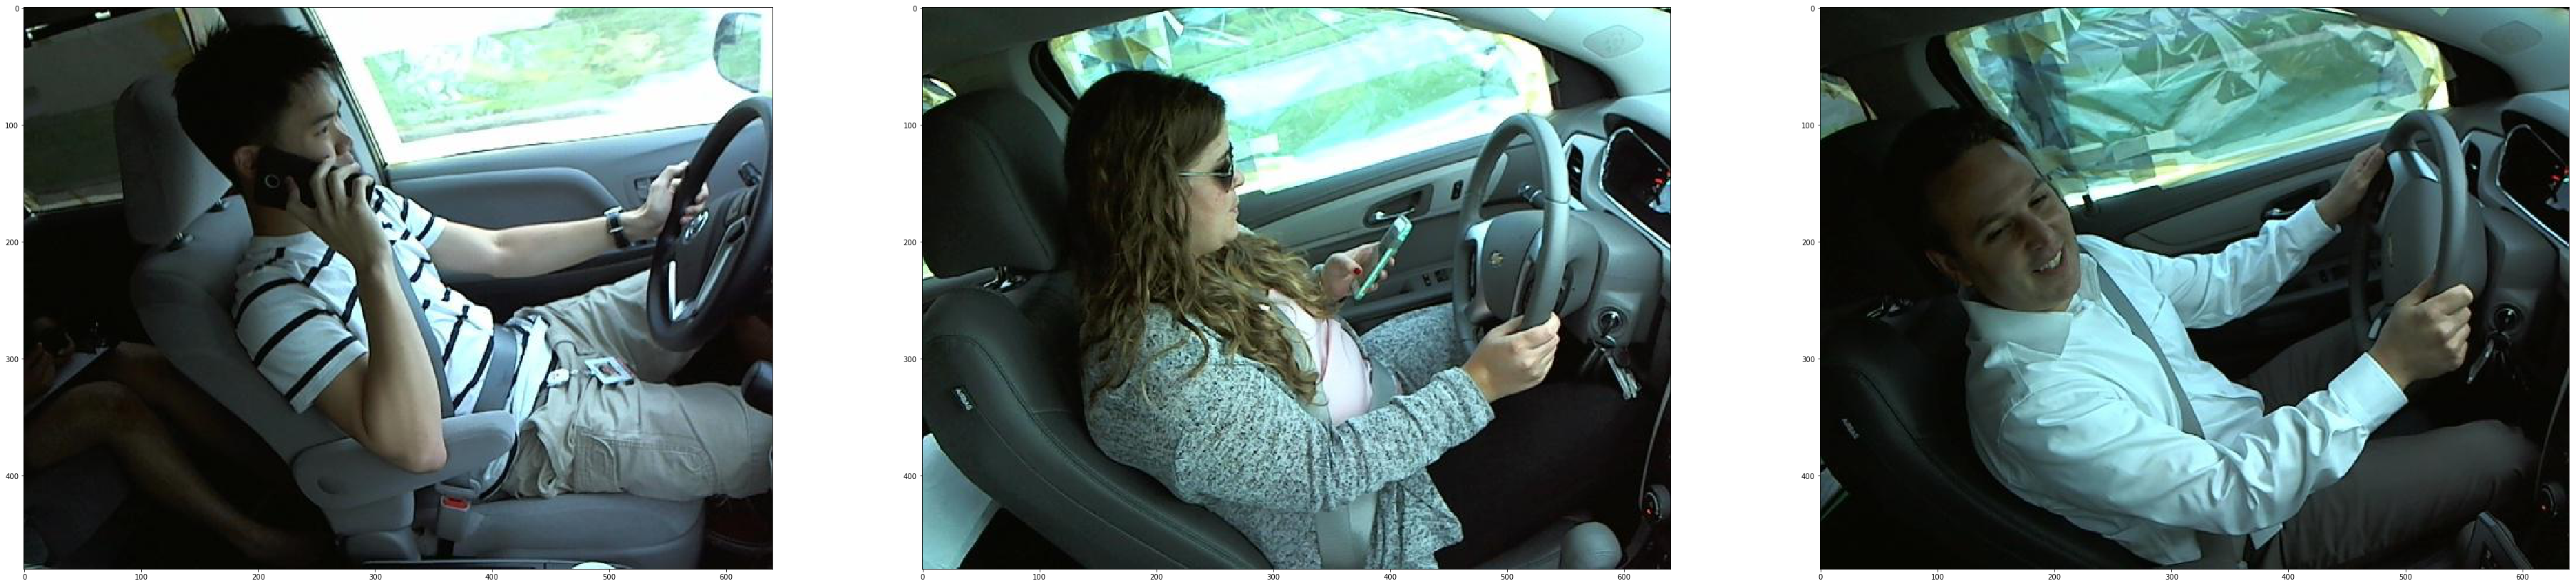

In [4]:
# Random visualize some image data
samples = np.random.choice(train_files, 3)
imgs = []
for sample in samples: 
    img = mpimg.imread(sample)
    imgs.append(img)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(64, 48))
ax1.imshow(imgs[0])
ax2.imshow(imgs[1])
ax3.imshow(imgs[2])
plt.show()

# Model building

I want to use transfer learning to boost the performance, and to obtain a proper weighted top layer, I first have to get the bottleneck features from my own dataset and then train the top layer with bottleneck features as inputs

### About preprocess_input

Getting the 4D tensor ready for VGG19, and for any other pre-trained model in Keras, requires some additional processing. For example, for VGG19, first, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.

In [5]:
# Hyperparameters setting
batch_size = 1
epochs = 20
target_size=(299, 299)

In [6]:
InceptionV3_model = InceptionV3(include_top=False, weights='imagenet')

In [7]:
# I had to conduct data split with Sklearn's `train_test_split ` for later use in the bottleneck training process
# as ImageDataGenerator do not return data labels after the data augumentation
# bacause for most of the time, the training is done with `fit_generator()`
X_train, X_valid, y_train, y_valid = train_test_split(train_files, train_labels, test_size=0.2)

In [8]:
y_train

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)

In [9]:
# Helper functions to process the training and validation data
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(path) for path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
X_train_data = preprocess_input(paths_to_tensor(X_train)) / 255
X_valid_data = preprocess_input(paths_to_tensor(X_valid)) / 255

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 138.01it/s]


In [11]:
bottleneck_features_training = InceptionV3_model.predict(X_train_data)
bottleneck_features_validation = InceptionV3_model.predict(X_valid_data)

np.savez('bottleneck_features_train.npz', 
         training=bottleneck_features_training, 
         validation=bottleneck_features_validation)

In [12]:
bottleneck_features = np.load('bottleneck_features_train.npz')
training_data = bottleneck_features['training']
validation_data = bottleneck_features['validation']

In [30]:
# The top layers are built making reference to the original InceptionV3 model
# However further modifications maybe needed
model = Sequential()
# The input shape from bottleneck_feature is (data_size, 8, 8, 2048)
model.add(GlobalAveragePooling2D(input_shape=training_data.shape[1:]))
model.add(Dense(10, name='top'))
# I run into a Keras and Tensorflow compatibility issue and using blow line as a bypass solution
model.add(Lambda(lambda x: K.tf.nn.softmax(x)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
top (Dense)                  (None, 10)                20490     
_________________________________________________________________
lambda_2 (Lambda)            (None, 10)                0         
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the mode, with optimizer as `rmsprop`
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Set checkpointer for training callbacks
checkpointer = ModelCheckpoint(filepath='saved_models/bottleneck_weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

model.fit(training_data, y_train, 
          validation_data=(validation_data, y_valid),
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks=[checkpointer], 
          verbose=1)


Epoch 00001: val_loss improved from inf to 9.53532, saving model to saved_models/bottleneck_weights.best.hdf5

Epoch 00002: val_loss did not improve from 9.53532

Epoch 00003: val_loss did not improve from 9.53532

Epoch 00004: val_loss did not improve from 9.53532

Epoch 00005: val_loss did not improve from 9.53532

Epoch 00006: val_loss did not improve from 9.53532

Epoch 00007: val_loss did not improve from 9.53532

Epoch 00008: val_loss did not improve from 9.53532

Epoch 00009: val_loss did not improve from 9.53532

Epoch 00010: val_loss did not improve from 9.53532

Epoch 00011: val_loss did not improve from 9.53532

Epoch 00012: val_loss did not improve from 9.53532

Epoch 00013: val_loss did not improve from 9.53532

Epoch 00014: val_loss did not improve from 9.53532

Epoch 00015: val_loss did not improve from 9.53532

Epoch 00016: val_loss did not improve from 9.53532

Epoch 00017: val_loss did not improve from 9.53532

Epoch 00018: val_loss did not improve from 9.53532

Epoc

In [34]:
# Examine the training result manually
model.load_weights('saved_models/bottleneck_weights.best.hdf5')
# get index of predictions each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in validation_data]

# report test accuracy
validation_accuracy = 100 * np.sum(np.array(predictions)==np.argmax(y_valid, axis=1))/len(predictions)

print("Test accuracy: {:.4f}%".format(validation_accuracy))

Test accuracy: 0.0000%


# Finetuning the model 

In [56]:
# Better provide the input shape to made the summary more readible
input_tensor = Input(shape=(299, 299, 3))

base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_tensor=input_tensor)

top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(10, name='top'))
top_model.add(Lambda(lambda x: K.tf.nn.softmax(x)))

# Load the pretrained weights to current top_model
top_model.load_weights('saved_models/bottleneck_weights.best.hdf5')
print("Pre-trained weights are loaded.")

tuning = Model(inputs=base_model.input, outputs=top_model(base_model.output))

for layer in tuning.layers[:250]:
    layer.trainable = False

tuning.summary()

Pre-trained weights are loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, 149, 149, 32) 96          conv2d_471[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, 149, 149, 32) 0           batch_normalization_471[0][0]    
_____________________________________________________________________________

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 35, 35, 256)  0           activation_476[0][0]             
                                                                 activation_478[0][0]             
                                                                 activation_481[0][0]             
                                                                 activation_482[0][0]             
__________________________________________________________________________________________________
conv2d_486 (Conv2D)             (None, 35, 35, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_486 (BatchN (None, 35, 35, 64)   192         conv2d_486[0][0]                 
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_490 (BatchN (None, 35, 35, 64)   192         conv2d_490[0][0]                 
__________________________________________________________________________________________________
batch_normalization_492 (BatchN (None, 35, 35, 64)   192         conv2d_492[0][0]                 
__________________________________________________________________________________________________
batch_normalization_495 (BatchN (None, 35, 35, 96)   288         conv2d_495[0][0]                 
__________________________________________________________________________________________________
batch_normalization_496 (BatchN (None, 35, 35, 64)   192         conv2d_496[0][0]                 
__________________________________________________________________________________________________
activation_490 (Activation)     (None, 35, 35, 64)   0           batch_normalization_490[0][0]    
__________

batch_normalization_508 (BatchN (None, 17, 17, 128)  384         conv2d_508[0][0]                 
__________________________________________________________________________________________________
activation_503 (Activation)     (None, 17, 17, 128)  0           batch_normalization_503[0][0]    
__________________________________________________________________________________________________
activation_508 (Activation)     (None, 17, 17, 128)  0           batch_normalization_508[0][0]    
__________________________________________________________________________________________________
average_pooling2d_49 (AveragePo (None, 17, 17, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_501 (Conv2D)             (None, 17, 17, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_504

__________________________________________________________________________________________________
batch_normalization_511 (BatchN (None, 17, 17, 192)  576         conv2d_511[0][0]                 
__________________________________________________________________________________________________
batch_normalization_514 (BatchN (None, 17, 17, 192)  576         conv2d_514[0][0]                 
__________________________________________________________________________________________________
batch_normalization_519 (BatchN (None, 17, 17, 192)  576         conv2d_519[0][0]                 
__________________________________________________________________________________________________
batch_normalization_520 (BatchN (None, 17, 17, 192)  576         conv2d_520[0][0]                 
__________________________________________________________________________________________________
activation_511 (Activation)     (None, 17, 17, 192)  0           batch_normalization_511[0][0]    
__________

activation_530 (Activation)     (None, 17, 17, 192)  0           batch_normalization_530[0][0]    
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 17, 17, 768)  0           activation_521[0][0]             
                                                                 activation_524[0][0]             
                                                                 activation_529[0][0]             
                                                                 activation_530[0][0]             
__________________________________________________________________________________________________
conv2d_535 (Conv2D)             (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_535 (BatchN (None, 17, 17, 192)  576         conv2d_535[0][0]                 
__________

batch_normalization_544 (BatchN (None, 17, 17, 192)  576         conv2d_544[0][0]                 
__________________________________________________________________________________________________
activation_544 (Activation)     (None, 17, 17, 192)  0           batch_normalization_544[0][0]    
__________________________________________________________________________________________________
conv2d_541 (Conv2D)             (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_545 (Conv2D)             (None, 17, 17, 192)  258048      activation_544[0][0]             
__________________________________________________________________________________________________
batch_normalization_541 (BatchN (None, 17, 17, 192)  576         conv2d_541[0][0]                 
__________________________________________________________________________________________________
batch_norm

activation_554 (Activation)     (None, 8, 8, 384)    0           batch_normalization_554[0][0]    
__________________________________________________________________________________________________
batch_normalization_555 (BatchN (None, 8, 8, 192)    576         conv2d_555[0][0]                 
__________________________________________________________________________________________________
activation_547 (Activation)     (None, 8, 8, 320)    0           batch_normalization_547[0][0]    
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 8, 8, 768)    0           activation_549[0][0]             
                                                                 activation_550[0][0]             
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 8, 8, 768)    0           activation_553[0][0]             
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_12[0][0]             
                                                                 activation_564[0][0]             
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 10)           20490       mixed10[0][0]                    
Total params: 21,823,274
Trainable params: 21,788,842
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [44]:
# As the dataset is huge, I wanted to do real time data augumentation with keras
# `validation_split` is only support in Keras 2.2.0 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   preprocessing_function=preprocess_input, 
                                   validation_split=0.2)

valid_datagen = ImageDataGenerator(rescale=1./255, 
                                   preprocesing_function=preprocess_input)

In [45]:
# `subset` is only needed if `validation_split` is set
train_generator = train_datagen.flow_from_directory(data_directory, 
                                                    target_size=(299, 299), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="training",
                                                    shuffle=True)

Found 20 images belonging to 10 classes.


In [46]:
validation_generator = valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=(299, 299), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="validation",
                                                    shuffle=False)

Found 0 images belonging to 10 classes.


In [48]:
tuning.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.5), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/finetuning_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

tuning.fit_generator(train_generator, epochs=epochs, 
                     validation_data=validation_generator, 
                     validation_steps=1000, 
                     callbacks=[checkpointer], 
                     verbose=1)

In [ ]:
scores = tuning.predict_generator(validation_generator)
